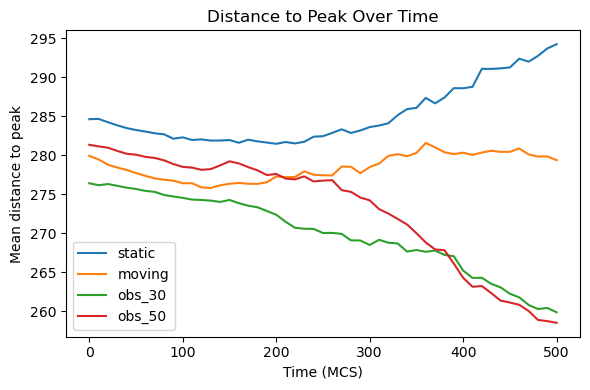

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_condition(name):
    dfs = []
    for i in (1,2,3):
        dfs.append(pd.read_csv(f"{name}{i}.csv"))
    return pd.concat(dfs, ignore_index=True)

def add_distance_to_peak(df):
    df['dist_peak'] = ((df.cx - df.peak_x)**2 + (df.cy - df.peak_y)**2)**0.5
    return df
conds = {'static': load_condition('base'),'moving': load_condition('moving'),'obs_30': load_condition('30moving_with_obstacles'),
 'obs_50': load_condition('50moving_with_obstacles'),}

plt.figure(figsize=(6,4))
for label, df in conds.items():
    df = add_distance_to_peak(df)
    mean_dist = df.groupby('time')['dist_peak'].mean()
    plt.plot(mean_dist.index, mean_dist.values, label=label)

plt.xlabel('Time (MCS)')
plt.ylabel('Mean distance to peak')
plt.title('Distance to Peak Over Time')
plt.legend()
plt.tight_layout()
plt.show()


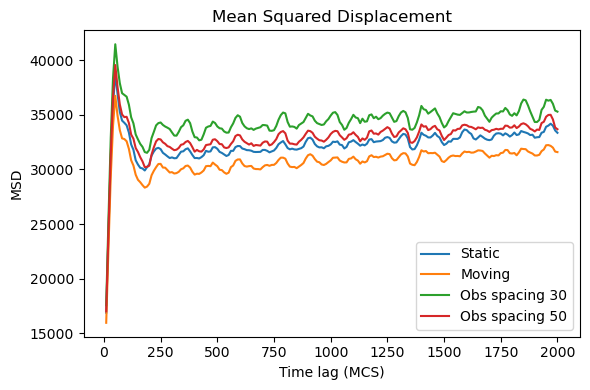

In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_files(pattern):
    files = sorted(glob.glob(pattern))
    return files

def load_condition(pattern):
    dfs = [pd.read_csv(f) for f in get_files(pattern)]
    return pd.concat(dfs, ignore_index=True)

def compute_msd_fast(df, max_lag=200, dt=10):
    cell_trajs = [grp.sort_values('time')[['cx','cy']].values for _, grp in df.groupby('cell')]
    lags = np.arange(1, max_lag+1)
    msd = np.empty_like(lags, dtype=float)

    for i, lag in enumerate(lags):
        disp2_list = []
        for traj in cell_trajs:
            n = traj.shape[0]
            if n > lag:
                delta = traj[lag:] - traj[:-lag]          
                disp2_list.append((delta**2).sum(axis=1))  
        msd[i] = np.concatenate(disp2_list).mean() if disp2_list else np.nan

    return lags * dt, msd

conditions = {'Static': 'base*.csv','Moving': 'moving*.csv','Obs spacing 30': '30moving_with_obstacles*.csv','Obs spacing 50': '50moving_with_obstacles*.csv',}

plt.figure(figsize=(6,4))

for label, pattern in conditions.items():
    df = load_condition(pattern)
    lags, mean_msd = compute_msd_fast(df)
    plt.plot(lags, mean_msd, label=label)

plt.xlabel('Time lag (MCS)')
plt.ylabel('MSD')
plt.title('Mean Squared Displacement')
plt.legend()
plt.tight_layout()
plt.show()


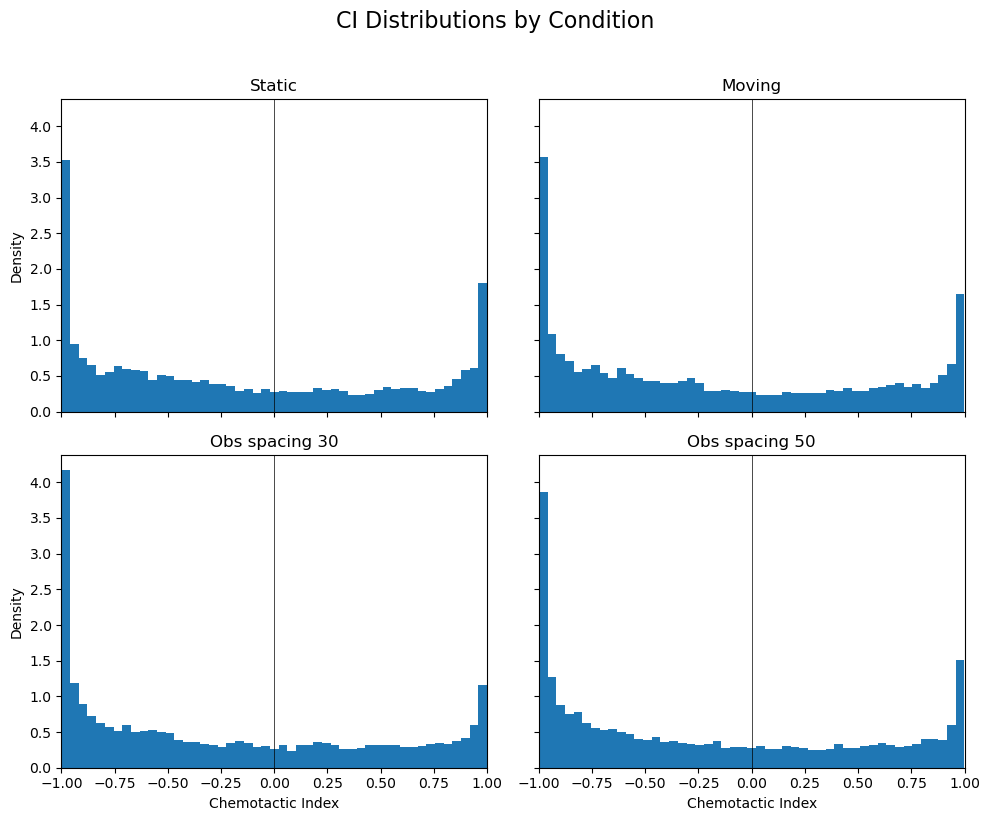

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_condition(name):
    dfs = [pd.read_csv(f"{name}{i}.csv") for i in (1,2,3)]
    return pd.concat(dfs, ignore_index=True)

def compute_CI(df, eps=1e-3):
    df = df.sort_values(['cell','time'])
    df[['dx','dy']] = df.groupby('cell')[['cx','cy']].diff()
    df['gx'] = df.peak_x - df.cx
    df['gy'] = df.peak_y - df.cy
    num = df.dx*df.gx + df.dy*df.gy
    den = np.hypot(df.dx, df.dy)*np.hypot(df.gx, df.gy)
    CI = num/den
    mask = (np.hypot(df.dx, df.dy) > eps) & (den > 0)
    return CI[mask]

conds = {'Static': load_condition('base'), 'Moving':load_condition('moving'),'Obs spacing 30': load_condition('30moving_with_obstacles'),'Obs spacing 50': load_condition('50moving_with_obstacles'),}

bins = np.linspace(-1, 1, 50)

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
labels = list(conds.keys())

for idx, label in enumerate(labels):
    row, col = divmod(idx, 2)
    ax = axes[row, col]
    ci_vals = compute_CI(conds[label])
    
    ax.hist(ci_vals, bins=bins, density=True)
    ax.set_title(label)
    ax.axvline(0, color='k', lw=0.5)
    ax.set_xlim(-1, 1)
    if row == 1:
        ax.set_xlabel('Chemotactic Index')
    if col == 0:
        ax.set_ylabel('Density')

fig.suptitle('CI Distributions by Condition', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


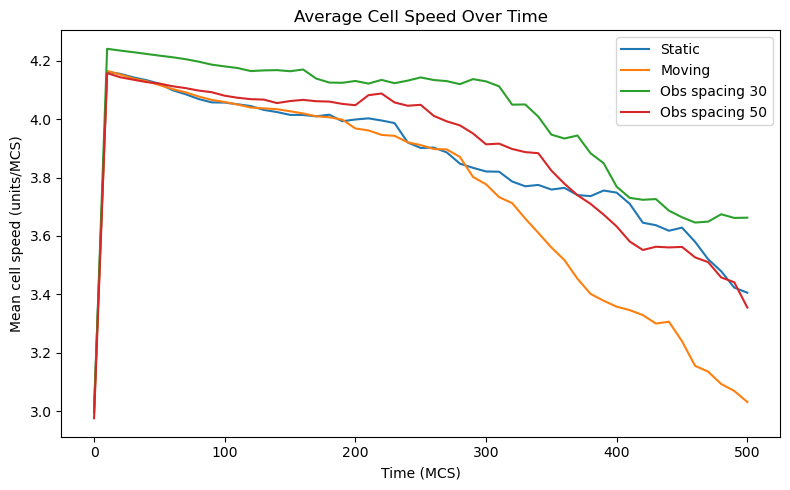

In [4]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_condition(pattern):
    files = sorted(glob.glob(pattern))
    dfs = [pd.read_csv(f) for f in files]
    return pd.concat(dfs, ignore_index=True)

def compute_speeds(df, dt=10):
    df = df.sort_values(['cell','time'])
    df['dx'] = df.groupby('cell')['cx'].diff()
    df['dy'] = df.groupby('cell')['cy'].diff()
    df['speed'] = np.sqrt(df['dx']**2 + df['dy']**2) / dt
    return df

speed_time = {}

for label, pattern in conditions.items():
    df = load_condition(pattern)
    df = compute_speeds(df)
    speed_time[label] = df.groupby('time')['speed'].mean()

plt.figure(figsize=(8, 5))
for label, series in speed_time.items():
    plt.plot(series.index, series.values, label=label)
plt.xlabel('Time (MCS)')
plt.ylabel('Mean cell speed (units/MCS)')
plt.title('Average Cell Speed Over Time')
plt.legend()
plt.tight_layout()
plt.show()
